# Outliers & Nonlinearity Robust Risk Analysis

Much of the theory and practice of quantitative asset management is routed in implicitly or explicitly assuming that asset returns are i.i.d. Gaussian, despite well documented empirical evidence to the contrary. From the widespread use of linear regression and regularized versions thereof (e.g. LASSO, Ridge and Elastic-Net) in signal construction, to the use of Pearson's correlation to measure risk, to the use of CAPM's beta and alpha coefficients to measure market exposure and idiosyncratic expected return respectively, examples abound.

However, relaxing the i.i.d. Gaussian assumption could be a daunting undertaking to some quants, and academic models that do so might not necessarily be robust enough for production use. This is where the `kxy` package comes in.

In this tutorial, we illustrate how the `kxy` package can be used as drop-in replacement of estimators of standard risk measures such as Pearson's correlation and linear risk factor models (e.g. CAPM's beta) that assume samples are *Gaussian* or, equivalently, linearly related, when empirical evidence suggest otherwise.

Specifically, we show that S&P 100 daily stock returns suffer from outliers and nonlinearities, stylized facts that go against the *Gaussian* assumption for daily stock returns, and we illustrate that the estimators provided in the `kxy` package are robust to both.

## I - Outliers or Nonlinearities?
Although nonlinearities and outliers might appear to be synonymous, we consider outliers to be observations that are small in number, extreme in magnitude, and best explained as belonging to a different distribution than the rest of the data. E.g. recording errors and asset returns in crisis situations. 

Data that constitute evidence of nonlinearities on the other hand tend to be larger in number, also extreme in magnitude, but are best explained as belonging to the tails of the same distribution as the rest of the data.

##  II - The Data
We illustrate how to perform outlier-robust and nonlinearity-robust risk analysis using the `kxy` package and the unofficial Yahoo Finance API. 

We query daily prices for stocks in the S&P 100, as well as the S&P 500 index.

In [1]:
import os

import numpy as np
import pandas as pd
import pylab as plt

import kxy
from yahooquery import Ticker
tickers = Ticker('aapl abbv abt acn adbe aig all amgn amt amzn axp '\
                 'ba bac biib bk bkng blk bmy brk-b c cat chtr cl '\
                 'cmcsa cof cop cost crm csco cvs cvx dd dhr dis '\
                 'dow duk emr exc f fb fdx gd ge gild gm goog googl '\
                 'gs hd hon ibm intc jnj jpm khc kmi ko lly lmt low '\
                 'ma mcd mdlz mdt met mmm mo mrk ms msft nee nflx '\
                 'nke nvda orcl oxy pep pfe pg pm pypl qcom rtx sbux '\
                 'slb so spg t tgt tmo txn unh unp ups usb v vz wba '\
                 'wfc wmt xom ^gspc')

In [2]:
prices_df = tickers.history(period='2y')

In [3]:
all_closes = prices_df['adjclose'].reset_index()
flat_closes = pd.concat([all_closes[all_closes['symbol'] == asset].rename(\
    columns={'adjclose': asset}).set_index(['date'])[[asset]]\
    for asset in list(set(all_closes['symbol'].values))], axis=1)
daily_returns = flat_closes.pct_change()

##  III - Beyond Pearson's Correlation Coefficient
Pearson's correlation is a good example of a widely used risk measure whose validity relies on the i.i.d. Gaussian assumption. 

In effect, it is a well-known fact that, in general, decorrelation does not imply statistical independence. Pearson's correlation only measures linear associations between random variables. Two random variables that are decorrelated but not independent will exhibit no linear association but will be nonlinearly related.

While linear associations are captured by Pearson's correlation, nonlinear associations are captured by higher moments. In other words, two random variables that are not linearly related but that are nonlinearly related will have dependent tail behaviors. If one undergoes a *black-swan* event, the other is likely to undergo one too. This is a particularly bad timing for dependence to occur as tail events typically have a much bigger business impact.

A notable exception is when both variables are jointly Gaussian. In such an event, decorrelation implies independence, and Pearson's correlation is as general a measure of risk as it gets. 

Unless variables are jointly Gaussian, Pearson's correlation should not be used as a measure of risk out-of-the-box. As we show below, stock returns are not Gaussian.

### 1 - Evidence of Outliers and Nonlinearities in Stock Returns
To test whether stock returns are Gaussian, and in so doing detect outliers and evidence of nonlinear association, we compare Pearson's correlation with Spearman's rank correlation.

The population version of Spearman's rank correlation reads $\rho(x, y) = 12E(uv)-3$ where $(u, v):=(F_x(x), F_y(y))$ are the copula-uniform dual representations (a.k.a the probability integral transform of $(x, y)$). 

We recall that $u$ and $v$ are both uniformly distributed on $[0,1]$ and, as such, have mean $\frac{1}{2}$ and variance $\frac{1}{12}$. Thus, Spearman's rank correlation is in fact the Pearson correlation between the copula-uniform dual representations. 

Considering that Gaussians are fully characterized by their first two moments, and that both correlations are translation invariant, that there is a one-to-one map between Pearson's and Spearman's correlations in the case of jointly Gaussian variables. 

We visualize the difference between the two correlations below.

In [4]:
import numpy as np
import pylab as plt
from scipy.integrate import dblquad
from scipy.stats import norm
from scipy.stats import multivariate_normal

def pearson_to_spearman(pc):
    f = lambda x, y: norm.cdf(x)*norm.cdf(y)*multivariate_normal([0., 0.],\
        [[1., pc], [pc, 1.]]).pdf([x, y])
    spc = dblquad(f, -np.inf, np.inf, lambda x: -np.inf, lambda x: np.inf,\
        epsabs=0.001, epsrel=0.001)
    return 12*spc[0]-3.

pearson_corrs = np.arange(-.95, 1., 0.05)
spearman_corrs = np.array([pearson_to_spearman(_) for _ in pearson_corrs])
pearson_corrs = np.array([-1.] + list(pearson_corrs) + [1.])
spearman_corrs = np.array([-1.] + list(spearman_corrs) + [1.])

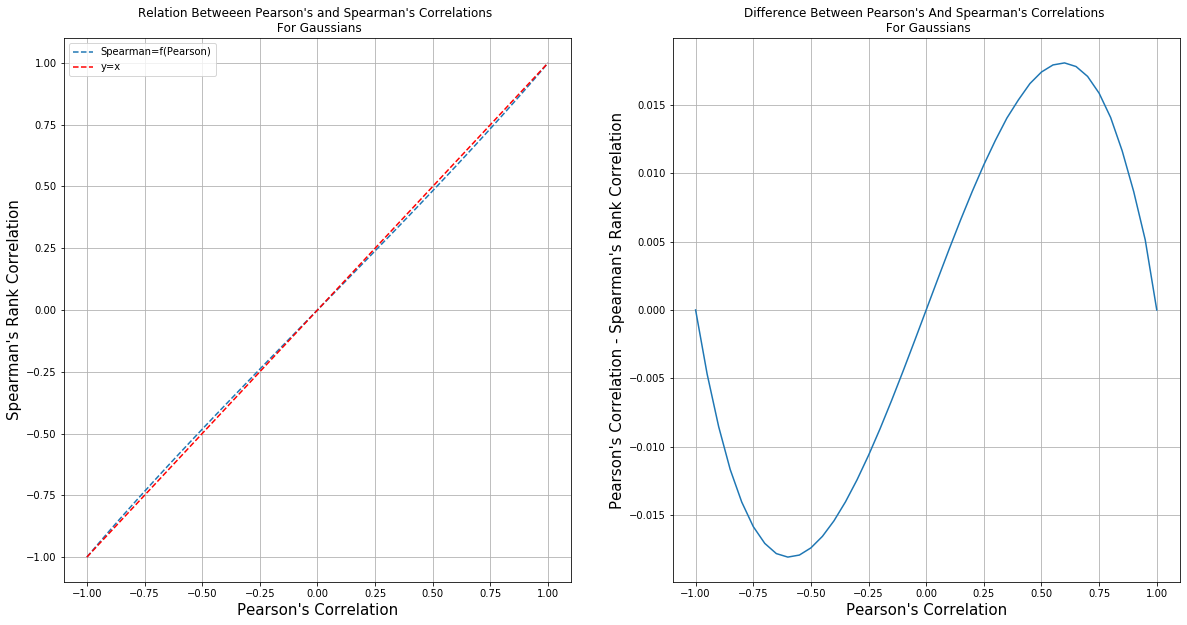

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].plot(pearson_corrs, spearman_corrs, '--', label='Spearman=f(Pearson)')
ax[0].plot(pearson_corrs, pearson_corrs, '--', label='y=x', c='r')
ax[0].set_ylabel("Spearman's Rank Correlation", fontsize=15)
ax[0].set_xlabel("Pearson's Correlation", fontsize=15)
ax[0].grid()
ax[0].set_title("Relation Betweeen Pearson's and Spearman's Correlations "
                "\n For Gaussians")
ax[0].legend()

ax[1].plot(pearson_corrs, pearson_corrs-spearman_corrs, '-')
ax[1].set_ylabel("Pearson's Correlation - Spearman's Rank Correlation", fontsize=15)
ax[1].set_xlabel("Pearson's Correlation", fontsize=15)
ax[1].set_title("Difference Between Pearson's And Spearman's Correlations "
                "\n For Gaussians")
plt.grid()

A difference between the *true* Pearson's and Spearman's correlations that deviates significantly from the rightmost plot above is strong evidence of nonlinearity. When sample estimators are used on the other hand, such a deviation could also be caused by outliers. 

Noting that the standard Spearman rank correlation estimator is robust to outliers (it only depends on rank data), while the standard Pearson's correlation estimator isn't, *if the Spearman rank correlation estimate is higher than the Pearson correlation estimate in absolute value by more than a few percentage points, then this is clear evidence of nonlinear association*.

When the Pearson correlation estimate is higher than the Spearman rank correlation estimate in absolute value by more than a few percentage points, it is most likely due to outliers. The bigger the difference, the more likely it is due to outliers rather than nonlinearities, and the bigger the outliers.

In [6]:
sp_corr = daily_returns.kxy.corr(method='spearman')
ps_corr = daily_returns.kxy.corr(method='pearson')

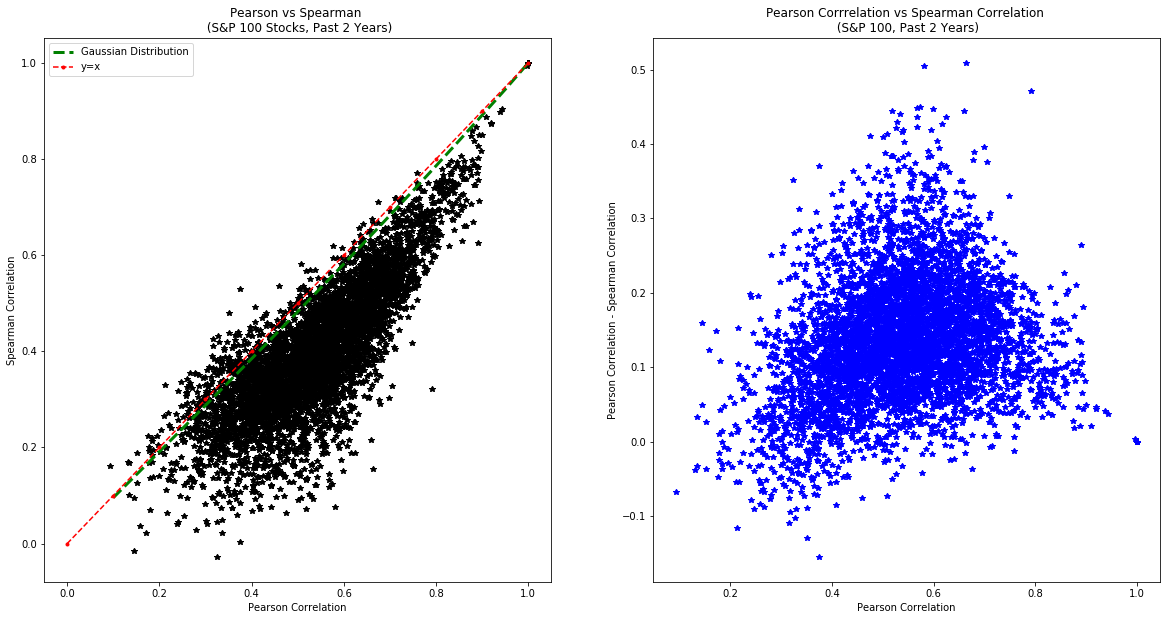

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].plot(ps_corr.values.flatten(), sp_corr.values.flatten(), '*',\
           c='black')
selector = np.logical_and(pearson_corrs>=ps_corr.values.min(), \
                          pearson_corrs<=ps_corr.values.max())
ax[0].plot(pearson_corrs[selector], spearman_corrs[selector], '--', \
        label='Gaussian Distribution', c='green', linewidth=3.0)
ax[0].plot(np.arange(0., 1.1, 0.1), np.arange(0., 1.1, 0.1), '.--', \
           c='red', label='y=x')
ax[0].set_xlabel('Pearson Correlation')
ax[0].set_ylabel('Spearman Correlation')
ax[0].set_title('Pearson vs Spearman \n (S&P 100 Stocks, Past 2 Years)')
ax[0].legend()

ax[1].plot(ps_corr.values.flatten(), (ps_corr-sp_corr).values.flatten(),\
           '*', c='blue')
ax[1].set_xlabel('Pearson Correlation')
ax[1].set_ylabel('Pearson Correlation - Spearman Correlation')
ax[1].set_title('Pearson Corrrelation vs Spearman Correlation \n '
                '(S&P 100, Past 2 Years)')
plt.show()

All those points that are so far away from the greeen line are strong indication of outliers and/or nonlinearities.

The `kxy` package provides two methods for estimating a correlation matrix while addressing the two limitations above.

### 2 - Outlier-Robust Pearson's Correlation Estimation
The `robust-pearson` method estimates a Pearson correlation matrix assuming variables are Gaussian, in a way that is robust to outliers. This is done by calculating the Spearman rank correlation matrix, and mapping each entry to the equivalent Pearson's correlation, assuming the corresponding pair of variables are jointly Gaussian. The robustness of this approach comes from the use of ranks instead of observed values in the calculation of a Spearman rank correlation. 

It is important to stress that the validity of this method, as an estimator of Pearson's correlation matrix *relies on the assumption that variables are Gaussian*. In particular, if $x$ and $y$ are two scalar random variables, and $f$ and $g$ are two increasing functions, this method will return the same result for all the pairs $(f(x), g(y))$ for *any* increasing functions $f$ and $g$, but it will only be a valid estimator of Pearson's correlation if $(f(x), g(y))$ are jointly Gaussian. 

Another way to look at this estimation method is that, often times, inputs are known not to be Gaussian, and a more realistic assumption is that there exists a feature mapping $(x_1, \dots, x_d) \to (f_1(x_1), \dots, f_d(x_d))$ that maps the non-Gaussian inputs into features that are jointly Gaussian. When the transformations $f_i$ are assumed to be **increasing** but are not explicitly needed, the `robust-pearson` method provides an estimator for the Pearson correlation matrix of the features, without having to learn the transformations making inputs Gaussian. It is only when the foregoing features transformations are assumed to be the identity $f_i(x_i)=x_i$ (i.e. when variables are assumed to be jointly Gaussian) that the `robust-pearson` method provides an estimator of the Pearson's correlation matrix of $(x_1, \dots, x_d)$.

In [8]:
rps_corr = daily_returns.kxy.corr(method='robust-pearson', p=0)

### 3 - Nonlinearity-Robust Correlation Estimation

The `information-adjusted` method estimates the Pearson correlation matrix that should be used to account for both linear and nonlinear associations in the data, and is robust to outliers. 

Specifically, for each pair of variables, we estimate their mutual information $i$ in a way that is both robust and captures nonlinear associations, and we infer the **information-adjusted** correlation as $\rho = \text{sgn}(c)\sqrt{1-e^{-2i}}$, where $c$ is the Pearson correlation. When empirical evidence suggest an absence of nonlinear association, the information-adjusted correlation is equal to Pearson's correlation. In general however, unlike Pearson's correlation, *the information-adjusted correlation is 0 if and only the two variables are statistically independent*. 

The current version of the `kxy` package estimates the mutual information $i$ by applying the [principle of maximum entropy](https://en.wikipedia.org/wiki/Principle_of_maximum_entropy) to each pair of variables, using as constraint their Spearman rank correlation.

While the `robust-pearson` method implicitly uses the workflow *Spearman Rank Correlation* $\rightarrow$ **Gaussian Copula** $\rightarrow$ *Mutual Information* $\rightarrow$ *Gaussian Mapping*, the `information-adjusted` method uses the workflow *Maximum-Entropy Constraints (e.g. Spearman Rank Correlation)* $\rightarrow$ **Maximum-Entropy Copula** $\rightarrow$ *Mutual Information* $\rightarrow$ *Gaussian Mapping*. 

When the Spearman rank correlation is used as maximum entropy constraint in the second workflow (as in the current version of the package), the estimated mutual-information will be smaller than the mutual information assumming the Gaussian copula (because the Gaussian copula is not the maximum-entropy copula under Spearman rank correlation constraints) and the `information-adjusted` correlation will be smaller in absolute value than the `robust-person` correlation. 

As more constraints are added to the maximum-entropy problem, the mutual information in the second workflow converges to the mutual information of the true (unknown) data generating distribution, and the information-adjusted correlation converges to the true Pearson correlation of any Gaussian features $(f_1(x_1), \dots, f_d(x_d))$ obtained through invertible maps.

Another way to look at this estimation method is that, often times, inputs are known not to be Gaussian, and a more realistic assumption is that there exists a feature mapping $(x_1, \dots, x_d) \to (f_1(x_1), \dots, f_d(x_d))$ that maps the non-Gaussian inputs into features that are jointly Gaussian. When the transformations $f_i$ are assumed to be **invertible** but are not explicitly needed, the `information-adjusted` method provides an estimator for the Pearson correlation matrix of the features, without having to learn the transformations making inputs Gaussian. It is only when the foregoing features transformations are assumed to be the identity $f_i(x_i)=x_i$ (i.e. when variables are assumed to be jointly Gaussian) that the `information-adjusted` method provides an estimator of the Pearson's correlation matrix of $(x_1, \dots, x_d)$.

In [9]:
ia_corr = daily_returns.kxy.corr(method='information-adjusted')

### 4 - Summary

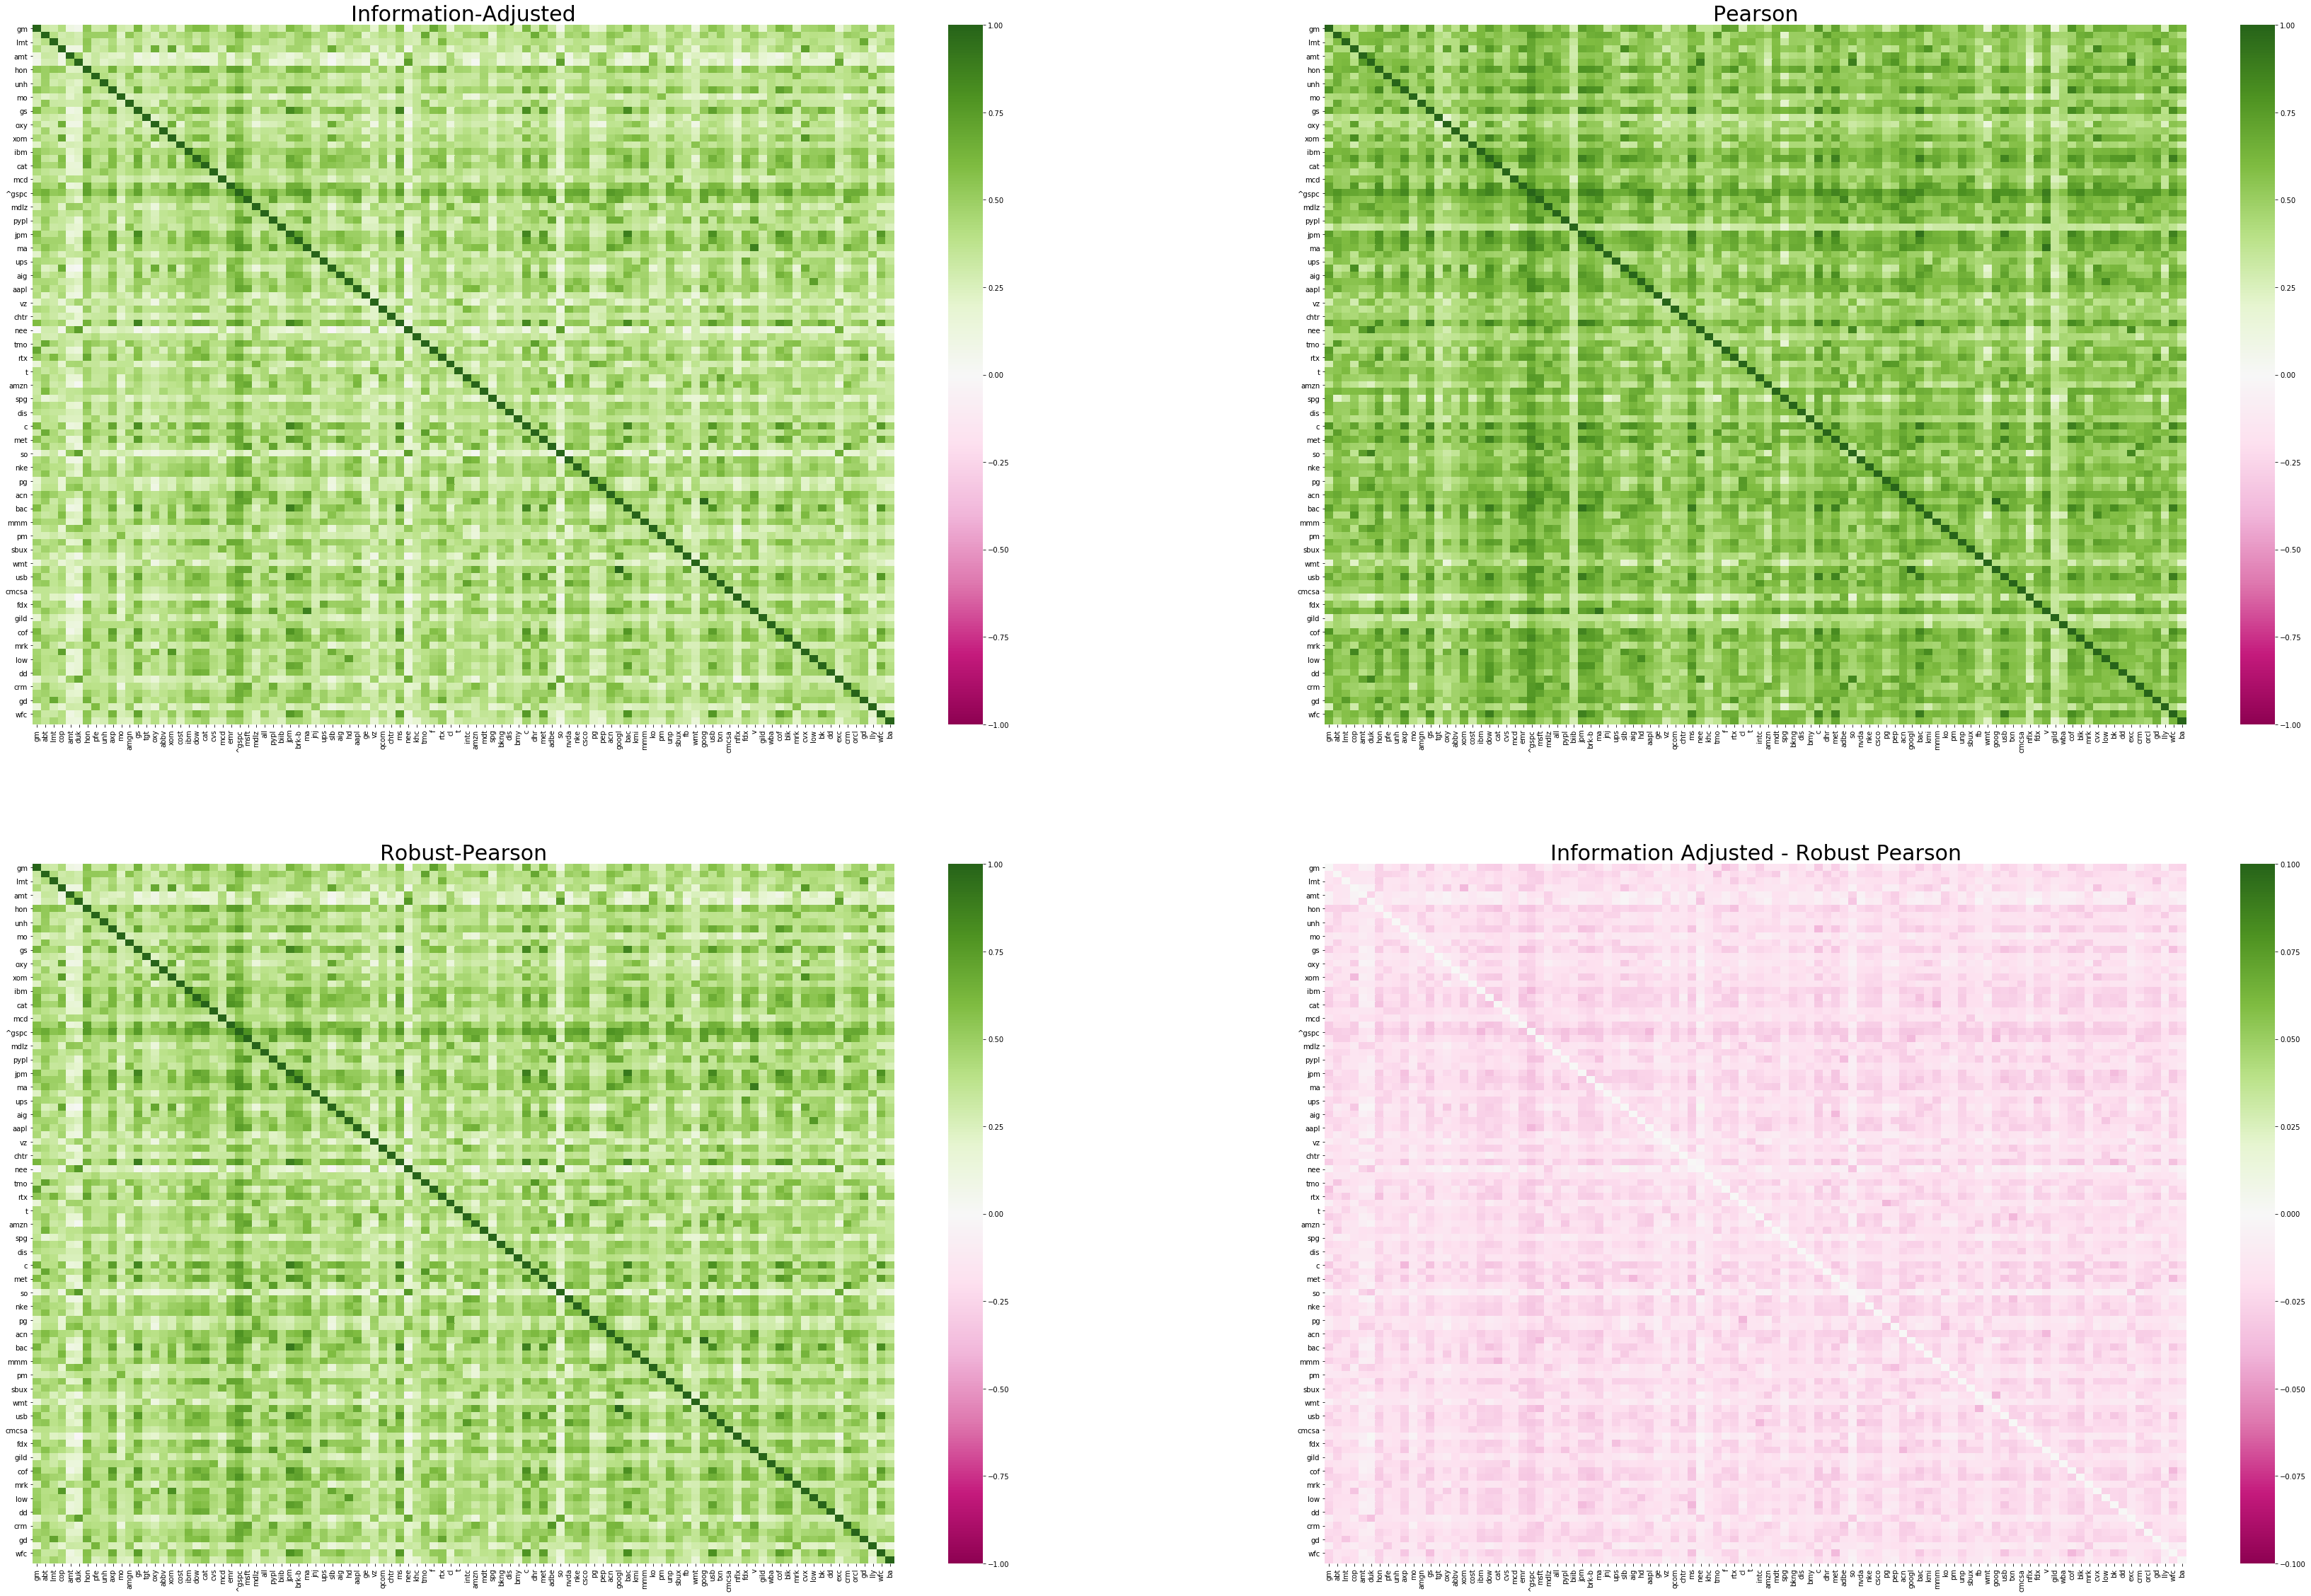

In [10]:
import seaborn as sns
fig, ax = plt.subplots(2, 2, figsize=(60, 40))
sns.heatmap(ia_corr, vmin=-1, vmax=1, center=0, cmap='PiYG', ax=ax[0, 0])
ax[0, 0].set_title('Information-Adjusted', fontsize=30)
sns.heatmap(rps_corr, vmin=-1, vmax=1, center=0, cmap='PiYG', ax=ax[1, 0])
ax[1, 0].set_title('Robust-Pearson', fontsize=30)
sns.heatmap(ps_corr, vmin=-1, vmax=1, center=0, cmap='PiYG', ax=ax[0, 1])
ax[0, 1].set_title('Pearson', fontsize=30)
sns.heatmap(ia_corr-rps_corr, vmin=-.1, vmax=.1, center=0, cmap='PiYG', ax=ax[1, 1])
ax[1, 1].set_title('Information Adjusted - Robust Pearson', fontsize=30)
plt.show()

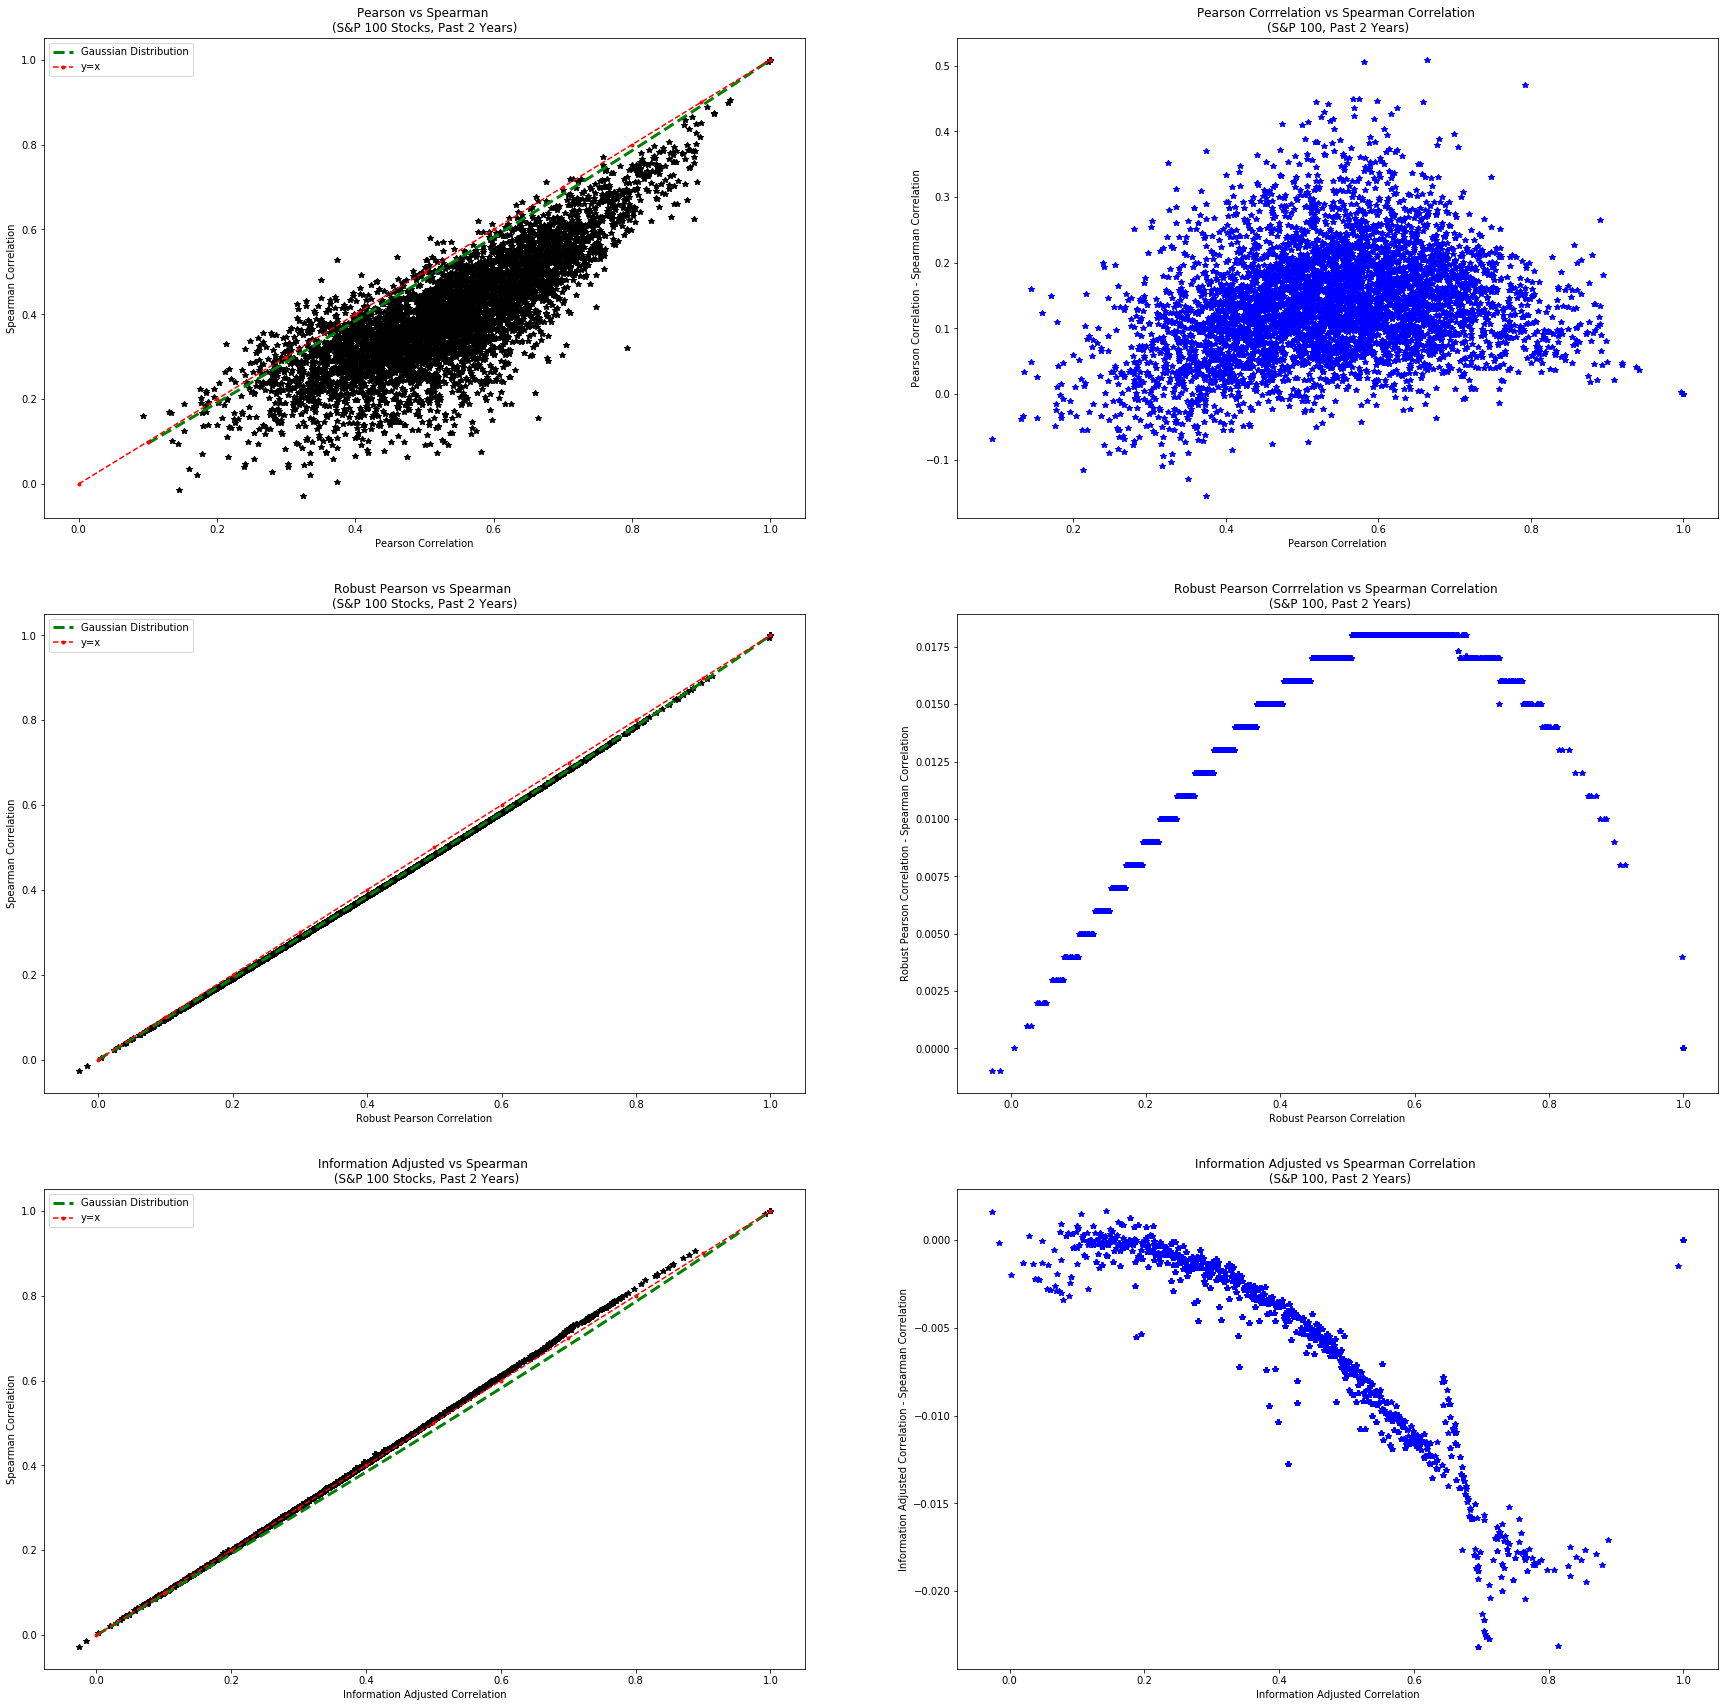

In [11]:
fig, ax = plt.subplots(3, 2, figsize=(30, 30))
ax[0, 0].plot(ps_corr.values.flatten(), sp_corr.values.flatten(),\
              '*', c='black')
selector = np.logical_and(pearson_corrs>=ps_corr.values.min(), \
                          pearson_corrs<=ps_corr.values.max())
ax[0, 0].plot(pearson_corrs[selector], spearman_corrs[selector], \
              '--', label='Gaussian Distribution', c='green',\
              linewidth=3.0)
ax[0, 0].plot(np.arange(0., 1.1, 0.1), np.arange(0., 1.1, 0.1), \
              '.--', c='red', label='y=x')
ax[0, 0].set_xlabel('Pearson Correlation')
ax[0, 0].set_ylabel('Spearman Correlation')
ax[0, 0].set_title('Pearson vs Spearman \n(S&P 100 Stocks, Past 2 Years)')
ax[0, 0].legend()

ax[0, 1].plot(ps_corr.values.flatten(), (ps_corr-sp_corr).values.flatten(),\
              '*', c='blue')
ax[0, 1].set_xlabel('Pearson Correlation')
ax[0, 1].set_ylabel('Pearson Correlation - Spearman Correlation')
ax[0, 1].set_title('Pearson Corrrelation vs Spearman Correlation \n '
                   '(S&P 100, Past 2 Years)')


ax[1, 0].plot(rps_corr.values.flatten(), sp_corr.values.flatten(),\
              '*', c='black')
selector = np.logical_and(pearson_corrs>=rps_corr.values.min(),\
            pearson_corrs<=rps_corr.values.max())
ax[1, 0].plot(pearson_corrs[selector], spearman_corrs[selector], '--', \
        label='Gaussian Distribution', c='green', linewidth=3.0)
ax[1, 0].plot(np.arange(0., 1.1, 0.1), np.arange(0., 1.1, 0.1), '.--', \
              c='red', label='y=x')
ax[1, 0].set_xlabel('Robust Pearson Correlation')
ax[1, 0].set_ylabel('Spearman Correlation')
ax[1, 0].set_title('Robust Pearson vs Spearman \n(S&P 100 Stocks, Past 2 Years)')
ax[1, 0].legend()

ax[1, 1].plot(rps_corr.values.flatten(), (rps_corr-sp_corr).values.flatten(),\
              '*', c='blue')
ax[1, 1].set_xlabel('Robust Pearson Correlation')
ax[1, 1].set_ylabel('Robust Pearson Correlation - Spearman Correlation')
ax[1, 1].set_title('Robust Pearson Corrrelation vs Spearman Correlation \n '
                   '(S&P 100, Past 2 Years)')


ax[2, 0].plot(ia_corr.values.flatten(), sp_corr.values.flatten(),\
              '*', c='black')
selector = np.logical_and(pearson_corrs>=ia_corr.values.min(),\
                          pearson_corrs<=ia_corr.values.max())
ax[2, 0].plot(pearson_corrs[selector], spearman_corrs[selector],\
              '--', label='Gaussian Distribution', c='green',\
              linewidth=3.0)
ax[2, 0].plot(np.arange(0., 1.1, 0.1), np.arange(0., 1.1, 0.1),\
              '.--', c='red', label='y=x')
ax[2, 0].set_xlabel('Information Adjusted Correlation')
ax[2, 0].set_ylabel('Spearman Correlation')
ax[2, 0].set_title('Information Adjusted vs Spearman \n '
                   '(S&P 100 Stocks, Past 2 Years)')
ax[2, 0].legend()

ax[2, 1].plot(ia_corr.values.flatten(), (ia_corr-sp_corr).values.flatten(),\
              '*', c='blue')
ax[2, 1].set_xlabel('Information Adjusted Correlation')
ax[2, 1].set_ylabel('Information Adjusted Correlation - Spearman Correlation')
ax[2, 1].set_title('Information Adjusted vs Spearman Correlation \n '
                   '(S&P 100, Past 2 Years)')


plt.show()

Empirical evidence that daily stock returns are non-Gaussian are clear; they suffer from outliers and exhibit nonlinear associations. The effect this has on the standard Pearson correlation estimator is to make it overshoot or overestimate linear risk, which could result in overhedging of linear risk.

When asset returns are assumed *Gaussian*, given empirical evidence to the contrary, it is crucial to use estimation methods that would not inflate Pearson's correlation in the presence of outliers or fat tails.

##  IV - Beyond CAPM's $\beta$

The CAPM beta, defined as $\beta := \mathbb{C}\text{orr}\left(r, r_m\right) \sqrt{\frac{\mathbb{V}\text{ar}(r)}{\mathbb{V}\text{ar}(r_m)}}$, measures the first-order (linear) exposure of a portfolio or an asset returns $r$ to the market return $r_m$. The underlying assumption of the CAPM model is that $r$ and $r_m$ are jointly Gaussian and linearly related, and $\beta$ is often interpreted as the number of dollars of the market index one should sell to completely offset the market risk per dollar of asset/portfolio holdings. 

When Pearson's correlation is estimated using the standard sample estimator, and asset/portfolio and market returns either suffer from outliers or are not jointly normal, as illustrated above, the standard estimator for beta will result in poorly hedged portfolios.

To address these limitations, we provide beta estimation methods in the `kxy` package that mirror previously discussed correlation estimation methods, namely `pearson`, `robust-pearson`, and `information-adjusted`.

In [12]:
# Beta of S&P 100 stocks relative to the S&P 500 index
betas = pd.concat([daily_returns.kxy.beta('^gspc', method='information-adjusted')\
                   .rename(columns={'beta': 'Information-Adjusted (Memoryless)'}),\
                   daily_returns.kxy.beta('^gspc', method='robust-pearson', p=0)\
                   .rename(columns={'beta': 'Robust-Pearson (Memoryless)'}),\
                   daily_returns.kxy.beta('^gspc', method='pearson')\
                   .rename(columns={'beta': 'Standard Pearson'})], axis=1)

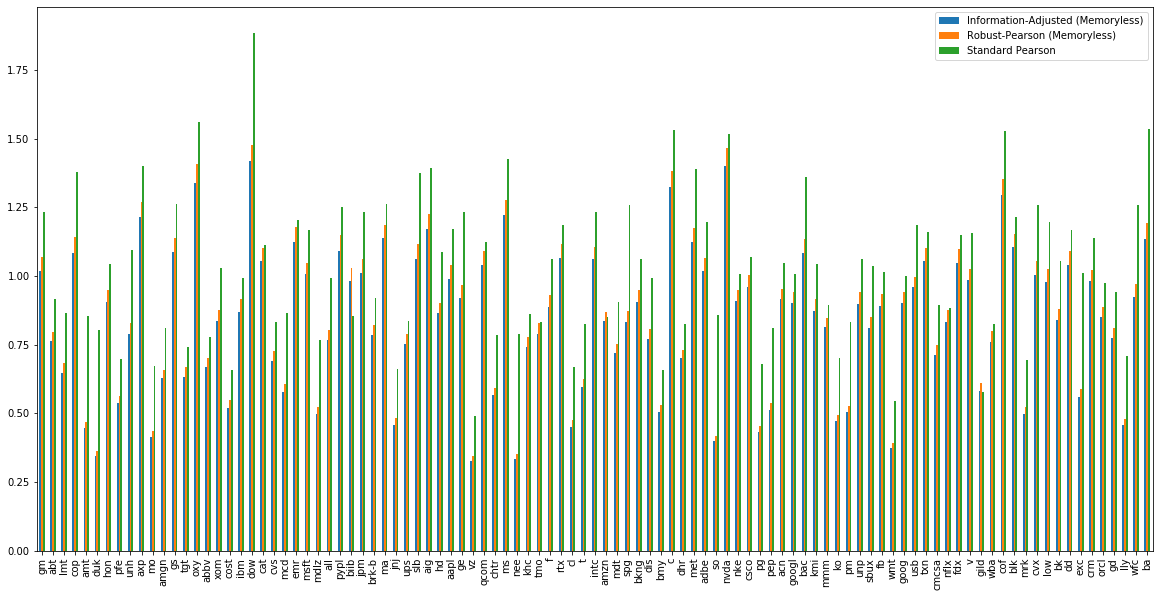

In [13]:
fig, ax = plt.subplots(figsize=(20, 10))
betas.plot.bar(ax=ax)
plt.show()

As illustrated in the figure above, the standard beta estimator can overshoot by up to 50% when estimating the beta of S&P 100 with respect to the S&P 100 index, leading to ineffective and costly hedging.

##  V - Final Thoughts

The **information-adjusted correlation coefficient** is a great drop-in replacement for Pearson's correlation in risk analysis in that it fully captures statistical independence, and coincides with Pearson's correlation when variables are Gaussian.

When asset returns are unduly assumed to be Gaussian, the `information-adjusted` method provides an approach for *quantifying and hedging* **linear/first order risk** in a manner that is robust to both outliers and fat-tails. However, tail risk is best handled by relaxing the Gaussian assumption itself. 

A weaker and more appropriate assumption is that, although variables might not be jointly Gaussian, they could be transformed into jointly Gaussian variables through invertible univariate feature transformations $(x_1, \dots, x_d) \to (f_1(x_1), \dots, f_d(x_d))$. 

When this assumption holds, the **information-adjusted correlation matrix** of $(x_1, \dots, x_d)$ is the Pearson correlation matrix of $(f_1(x_1), \dots, f_d(x_d))$, and its estimation (i.e. the `information-adjusted` correlation estimation method in the `kxy` package) does not require learning the transformations $f_i$.